## Analysis of Covid-19 in Germany

This project was completed by Crispen Chisina, Zhanarbek Osmonaliev and Htet Naing Phyo.

In [101]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

covid_de = pd.read_csv('covid_germany/covid_de.csv')
demographics_de = pd.read_csv('covid_germany/demographics_de.csv')
google_covid_de = pd.read_csv("covid_germany/de_comp_covid.csv")

In [102]:
covid_de.head()

state              county age_group gender        date  cases  \
0  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-03-27      1   
1  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-03-28      1   
2  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-04-03      1   
3  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-10-18      1   
4  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-10-22      1   

   deaths  recovered  
0       0          1  
1       0          1  
2       0          1  
3       0          1  
4       0          1

In [103]:
demographics_de.head()

state  gender age_group  population
0  Baden-Wuerttemberg  female     00-04      261674
1  Baden-Wuerttemberg  female     05-14      490822
2  Baden-Wuerttemberg  female     15-34     1293488
3  Baden-Wuerttemberg  female     35-59     1919649
4  Baden-Wuerttemberg  female     60-79     1182736

# Data cleaning

In [104]:
covid_de.date = pd.to_datetime(covid_de.date, infer_datetime_format = True)
google_covid_de.date = pd.to_datetime(google_covid_de.date, infer_datetime_format = True)
#convert the date column in the covid dataset to date time format

In [105]:
covid_de.dtypes

state                object
county               object
age_group            object
gender               object
date         datetime64[ns]
cases                 int64
deaths                int64
recovered             int64
dtype: object

## Missing Values

In [106]:
covid_de.isnull().sum()
# check for missing values

state            0
county           0
age_group     2244
gender       13916
date             0
cases            0
deaths           0
recovered        0
dtype: int64

In [107]:
demographics_de.isnull().sum()

state         0
gender        0
age_group     0
population    0
dtype: int64

In [108]:
covid_de[covid_de['gender'].isnull()].head(5)

state              county age_group gender       date  \
315  Baden-Wuerttemberg  LK Alb-Donau-Kreis     05-14    NaN 2020-10-30   
316  Baden-Wuerttemberg  LK Alb-Donau-Kreis     05-14    NaN 2020-11-19   
798  Baden-Wuerttemberg  LK Alb-Donau-Kreis     15-34    NaN 2020-10-28   
799  Baden-Wuerttemberg  LK Alb-Donau-Kreis     15-34    NaN 2020-10-30   
800  Baden-Wuerttemberg  LK Alb-Donau-Kreis     15-34    NaN 2020-11-01   

     cases  deaths  recovered  
315      1       0          1  
316      1       0          1  
798      1       0          1  
799      2       0          2  
800      1       0          1

In [109]:
covid_de[covid_de['age_group'].isnull()].head(5)

state              county age_group gender       date  \
1919  Baden-Wuerttemberg  LK Alb-Donau-Kreis       NaN      F 2020-10-26   
1920  Baden-Wuerttemberg  LK Alb-Donau-Kreis       NaN      F 2020-11-19   
1921  Baden-Wuerttemberg  LK Alb-Donau-Kreis       NaN      F 2020-12-24   
1922  Baden-Wuerttemberg  LK Alb-Donau-Kreis       NaN      M 2021-03-31   
6114  Baden-Wuerttemberg       LK Boeblingen       NaN      M 2021-01-30   

      cases  deaths  recovered  
1919      1       0          1  
1920      1       0          1  
1921      1       0          1  
1922      1       0          0  
6114      1       0          1

In [110]:
covid_de['age_group'].isnull().sum()/len(covid_de) * 100

# only 0.3246% in the age group column are missing so we can just drop the rows since it is a very small'
# percentages

0.32464056618240633

In [111]:
covid_de['gender'].isnull().sum()/len(covid_de) * 100
# only 2.01% of the entries in the gender column are missing so we can just drop the rows since it is a very small
# percentages

2.0132344558798425

In [112]:
# drop missing rows in age group rows
covid_de = covid_de[covid_de['age_group'].notna()]

In [113]:
# drop missing rows in gender group rows
covid_df = covid_de[covid_de['gender'].notna()]

In [114]:
covid_df.isnull().sum()

state        0
county       0
age_group    0
gender       0
date         0
cases        0
deaths       0
recovered    0
dtype: int64

In [115]:
vital_attributes = ["date", "new_confirmed", "new_deceased", "new_persons_fully_vaccinated", "mobility_retail_and_recreation", "mobility_grocery_and_pharmacy", "mobility_parks", "mobility_transit_stations", "mobility_workplaces", "mobility_residential", "testing_policy", "facial_coverings", "vaccination_policy", "average_temperature_celsius"]
google_covid_de.drop(google_covid_de.columns.difference(vital_attributes), axis=1, inplace=True)

## Duplicates

In [116]:
print('number of duplicated rows in "covid" :', covid_df.duplicated().sum())
print('')
print('number of duplicated rows in "demographics" :', demographics_de.duplicated().sum())

number of duplicated rows in "covid" : 0

number of duplicated rows in "demographics" : 0


In [117]:
covid_df[covid_df.duplicated(keep=False)].head()

Empty DataFrame
Columns: [state, county, age_group, gender, date, cases, deaths, recovered]
Index: []

In [118]:
# drop duplicate entries
covid_df = covid_df.drop_duplicates()
print('number of duplicated rows in "covid" :', covid_df.duplicated().sum())

number of duplicated rows in "covid" : 0


## Outliers

<AxesSubplot:>

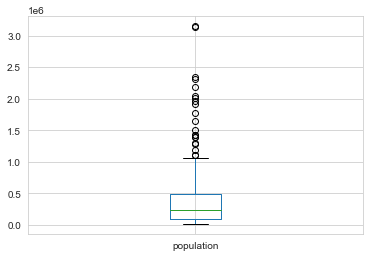

In [119]:
demographics_de.boxplot()

In [120]:
def outliers_loc(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    ind = df.index[(df[feature] <= lower_bound) | (df[feature] >= upper_bound)]
    return ind

# function to detect location of outliers using Interquartile range

In [121]:
def remove_out(df, indexes_ls):
    out_index_ls = sorted(set(indexes_ls))
    df = df.drop(out_index_ls)
    return df
# function to remove outliers given the location of the outliers

In [122]:
outlrs_loc = outliers_loc(demographics_de, 'population')
print('number of outliers in "demographics_de" :', len(outlrs_loc))

number of outliers in "demographics_de" : 21


In [123]:
new_demographics_cleaned =  remove_out(demographics_de, outlrs_loc)

<AxesSubplot:>

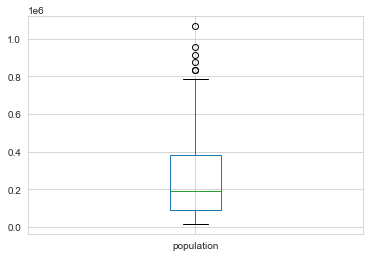

In [124]:
new_demographics_cleaned.boxplot()

In [125]:
len(outliers_loc(new_demographics_cleaned, 'population'))
# most of the outliers have been removed since
# we can not completely remove all outliers the 
# remaining 6 are negligable so we can leave them in the dataset

6

<AxesSubplot:>

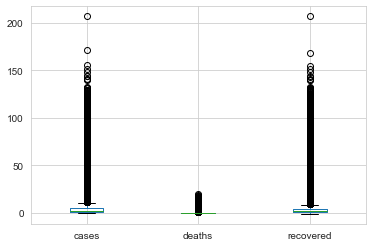

In [126]:
covid_df.boxplot()
# the covid dataset has alot of outliers

In [127]:
outlrs_indexes = outliers_loc(covid_df, 'cases')

In [128]:
len(outlrs_indexes)

59162

In [129]:
new_covid_df_cleaned =  remove_out(covid_df, outlrs_indexes)

<AxesSubplot:>

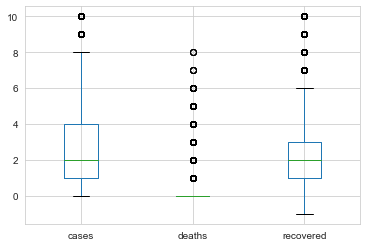

In [130]:
new_covid_df_cleaned.boxplot()
# most of the outliers have been removed and since we can not remove all
# we can just leave the remaining

In [131]:
new_demographics_cleaned = new_demographics_cleaned.replace(['female', 'male'], ['F', 'M'])

In [132]:
merged_data = new_covid_df_cleaned.merge(new_demographics_cleaned,
                                         how = 'inner', on = ['state', 'gender', 'age_group'])

# merge the cleaned demographics and covid dataset

In [133]:
merged_data.shape

(385640, 9)

__final data sets new_covid_df_cleaned, new_demographics_cleaned and merged_data__

#### Cleaning and Filling Missing Values in the Additional Dataset

1)  We will select the data starting from February 21th 2020 till May 2nd 2022, as it has almost no missing values.

2) Next, we fill in empty values in `new_persons_fully_vaccinated` and `cumulative_persons_fully_vaccinated` with 0s, since there were no vaccinated people recorded in the beginning of the pandemic.

3) Lastly, we drop incomplete columns, as the number of them is negligible in relation to the whole dataset.

In [134]:
google_covid_de.isnull().sum()

date                                0
new_confirmed                       5
new_deceased                        5
new_persons_fully_vaccinated      371
mobility_retail_and_recreation     50
mobility_grocery_and_pharmacy      50
mobility_parks                     50
mobility_transit_stations          50
mobility_workplaces                50
mobility_residential               50
testing_policy                      6
facial_coverings                    6
vaccination_policy                  6
average_temperature_celsius         9
dtype: int64

In [135]:
google_covid_de['new_persons_fully_vaccinated'] = google_covid_de['new_persons_fully_vaccinated'].fillna(0)
google_covid_de = google_covid_de[51:851]
google_covid_de.isnull().sum()

date                              0
new_confirmed                     0
new_deceased                      0
new_persons_fully_vaccinated      0
mobility_retail_and_recreation    0
mobility_grocery_and_pharmacy     0
mobility_parks                    0
mobility_transit_stations         0
mobility_workplaces               0
mobility_residential              0
testing_policy                    0
facial_coverings                  0
vaccination_policy                0
average_temperature_celsius       1
dtype: int64

In [136]:
google_covid_de = google_covid_de[google_covid_de['average_temperature_celsius'].notna()]
google_covid_de.isnull().sum()

date                              0
new_confirmed                     0
new_deceased                      0
new_persons_fully_vaccinated      0
mobility_retail_and_recreation    0
mobility_grocery_and_pharmacy     0
mobility_parks                    0
mobility_transit_stations         0
mobility_workplaces               0
mobility_residential              0
testing_policy                    0
facial_coverings                  0
vaccination_policy                0
average_temperature_celsius       0
dtype: int64

# Data Analysis

## Covid cases trend in Germany

In [137]:
covidcases_bydate = new_covid_df_cleaned.groupby('date').sum()
# find the sum for cases, deaths and recovered by date in order to visualize trends

In [138]:
covidcases_bydate.head()

cases  deaths  recovered
date                                
2020-01-07      1       0          1
2020-01-19      1       0          1
2020-01-23      1       0          1
2020-01-25      1       0          1
2020-01-28      2       0          2

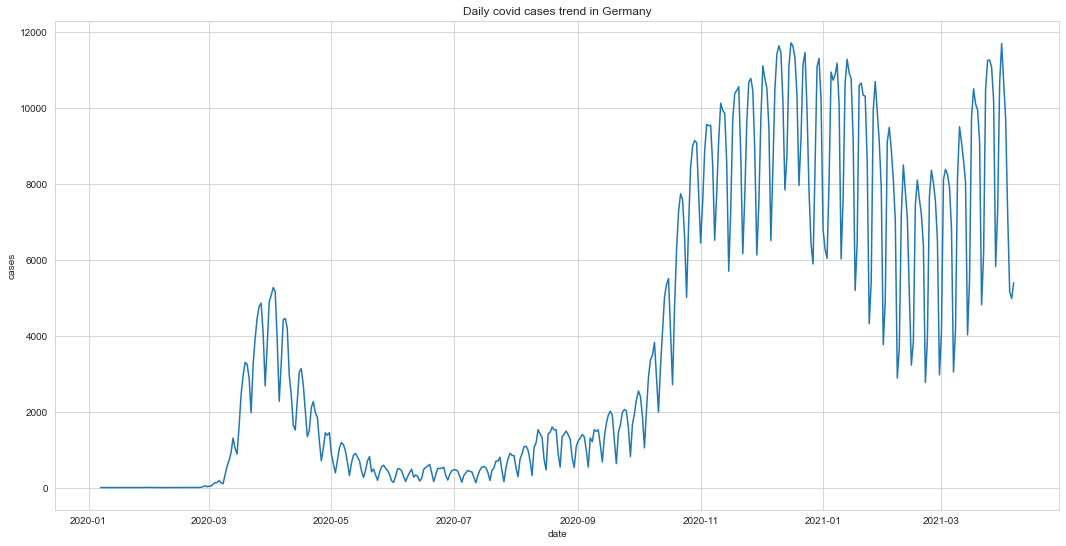

In [139]:
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
plt.figure(figsize=(18,9))
plt.title('Daily covid cases trend in Germany')
p=sns.lineplot(data=covidcases_bydate.cases)

* From the graph above it looks like there was a slight peak betwen March 2020 and May 2020, which was the time corona spread but there was a decline in cases after maybe because of lockdown measures
* However, there was a second wave in the start of 2021 because of the new variant and the number of cases peaked near the start of 2021.
* Moreover it also looks like in april there was another wave of surge of number of cases in april 2021

## Trend of cases by states

In [140]:
covid_bystate = new_covid_df_cleaned.groupby(by=["state", "date"]).sum()
# find the sum for cases, deaths and recovered by date and state in order to visualize trends

In [141]:
covid_bystate.reset_index(inplace=True)

In [142]:
covid_bystate.head()

state       date  cases  deaths  recovered
0  Baden-Wuerttemberg 2020-02-24      1       0          1
1  Baden-Wuerttemberg 2020-02-25      2       0          2
2  Baden-Wuerttemberg 2020-02-26      4       0          4
3  Baden-Wuerttemberg 2020-02-27      3       0          3
4  Baden-Wuerttemberg 2020-02-28      7       0          7

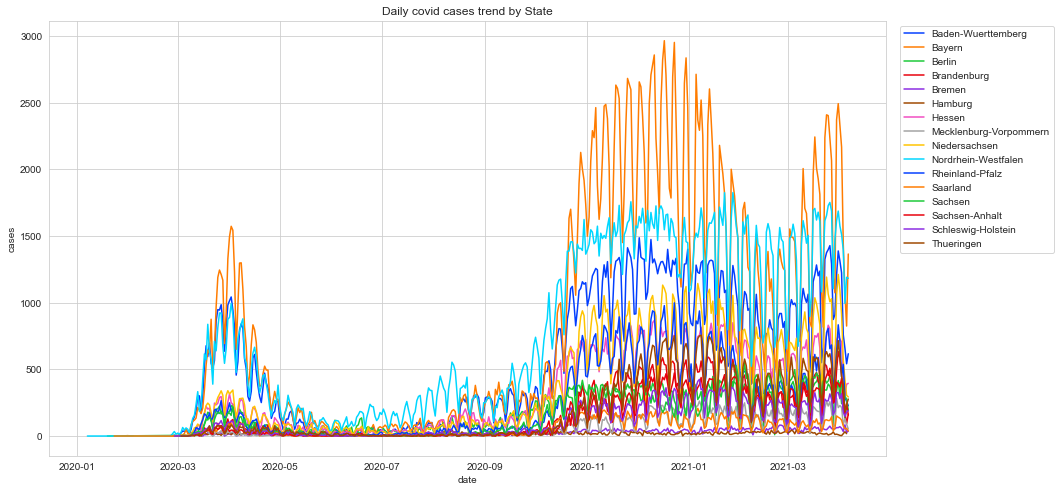

In [143]:
plt.figure(figsize=(15,8))
ln = sns.lineplot(data=covid_bystate, x="date", y="cases", hue="state", palette = 'bright')
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Daily covid cases trend by State")
plt.show()

* from the graph above one can see that in the peak monnths Bayern contributed more in the rise of cases in Germany
* however just comparing the numbers can be misleading because population sizes also plays a key part so it is bettter to compare the ratios population

In [144]:
cov_demo_df = merged_data.copy()

cov_demo_df['Cases per population'] = merged_data.cases/merged_data.population

cov_demo_df['Deaths per population'] = merged_data.deaths/merged_data.population

In [145]:
state_data = cov_demo_df.groupby('state').sum().sort_values('Cases per population', ascending=False)
state_data['Fatality'] = (state_data.deaths / state_data.cases) * 100

In [146]:
state_data.head()

cases  deaths  recovered   population  Cases per population  \
state                                                                           
Thueringen        75904    2922      67032   6242867987              0.438883   
Brandenburg       65225    2678      57138   6002839509              0.326002   
Saarland          24061     732      22147    936841656              0.312279   
Sachsen-Anhalt    52541    2021      45324   4043605652              0.306906   
Rheinland-Pfalz  104470    2958      93558  19854720609              0.299543   

                 Deaths per population  Fatality  
state                                             
Thueringen                    0.031175  3.849599  
Brandenburg                   0.024993  4.105788  
Saarland                      0.017114  3.042268  
Sachsen-Anhalt                0.020174  3.846520  
Rheinland-Pfalz               0.017746  2.831435

[]

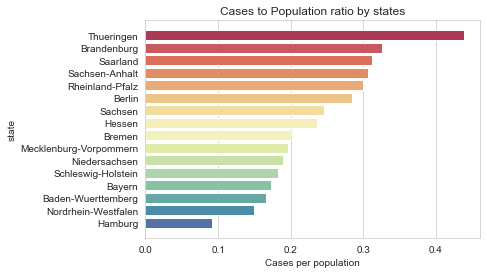

In [147]:
sns.barplot(data = state_data, x='Cases per population', y=state_data.index, palette='Spectral')
plt.title("Cases to Population ratio by states")
plt.plot()

* From the graph above one can see the full story that although Bayern contributed more to the spike in covid cases because it has a larger population but when we compare cases to population ratio bayern is one of the bottom 4 but Thueringen had the highest.

## Rates of Cases by State

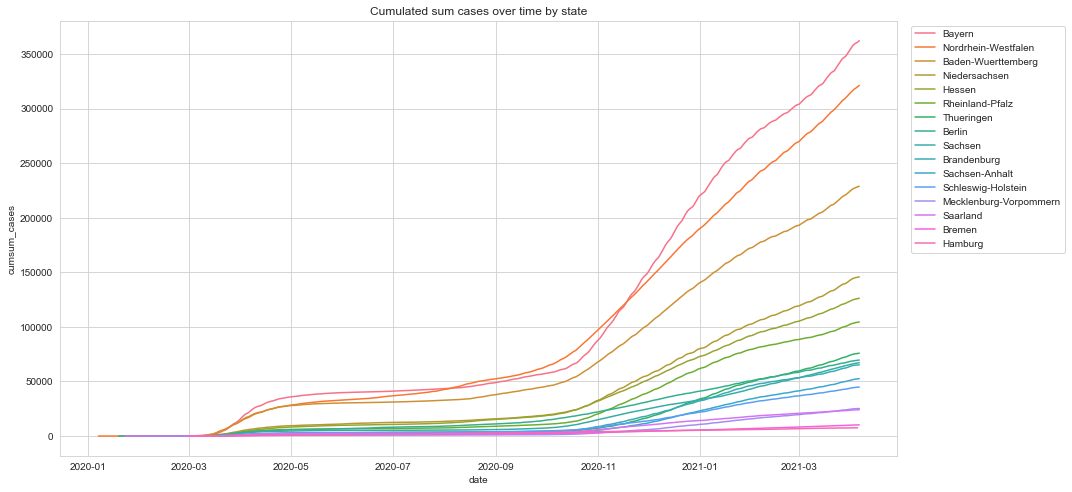

In [148]:
state_sum = new_covid_df_cleaned.groupby(by=["state", "date"]).sum()
state_sum = state_sum.replace([np.inf, -np.inf], 0)
state_sum["cumsum_cases"] = state_sum.groupby(level=-2)["cases"].cumsum()
state_sum = state_sum.reset_index()

plt.figure(figsize=(15,8))
ln = sns.lineplot(data=state_sum.sort_values("cumsum_cases", ascending=False), x="date", y="cumsum_cases", hue="state")
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Cumulated sum cases over time by state")
plt.show()

* from the graph above one can see that Bayern had the highest increasing rate and Hamburg had the lowest increasing rate

## Trend of Death by State

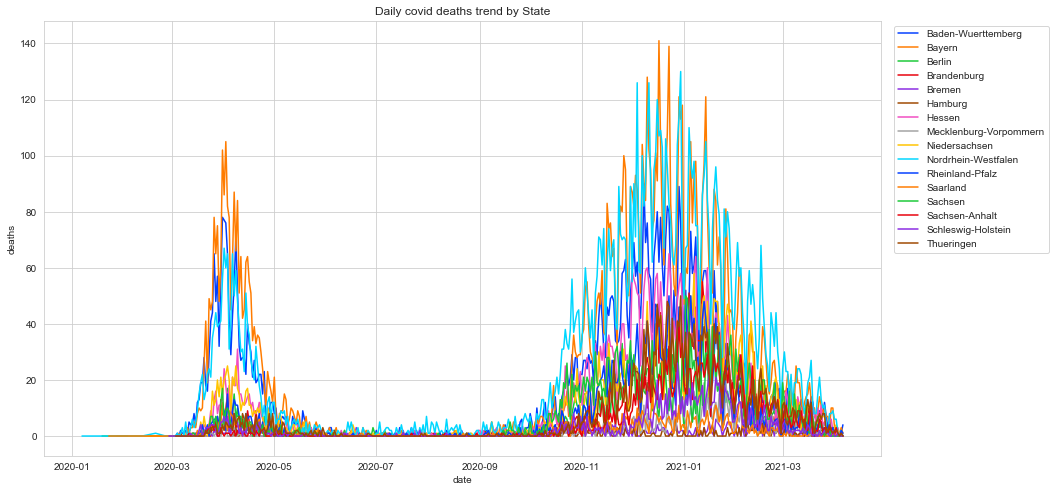

In [149]:
plt.figure(figsize=(15, 8))
ln = sns.lineplot(data=covid_bystate, x="date", y="deaths",
                  hue="state", palette='bright')
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Daily covid deaths trend by State")
plt.show()

* Highest deaths occured in Bayern and Nordhein-Westfalen states.
* Death cases in Nordhein-Westfalen seems to be relatively frequent even during the months when the cases died down. 

In [150]:
state_data = state_data.sort_values('Deaths per population', ascending=False)

[]

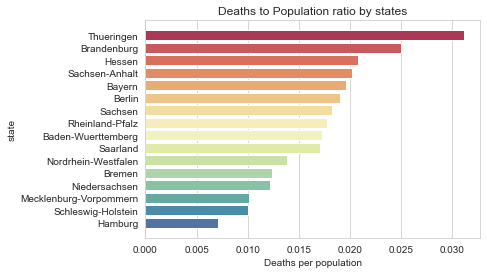

In [151]:

sns.barplot(data=state_data, x='Deaths per population',
            y=state_data.index, palette='Spectral')
plt.title("Deaths to Population ratio by states")
plt.plot()

* Supporting results in previous cases to population ratio graphs, Theringen state had highest Deaths to Population ratio. 

In [152]:
state_data = state_data.sort_values('Fatality', ascending=False)


[]

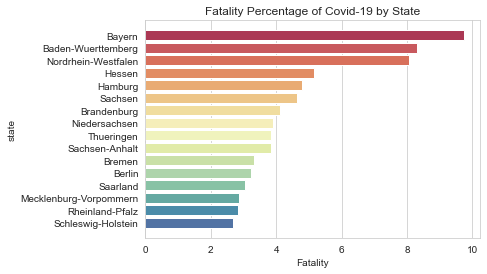

In [153]:
sns.barplot(data=state_data, x='Fatality',
            y=state_data.index, palette='Spectral')
plt.title("Fatality Percentage of Covid-19 by State")
plt.plot()


* Eventhough Death to Population ratio was smaller in state such as Bayern, in terms of Fatality, it is showing that states with bigger population and higher cases had more fatalities. 
* For example, in Bayern, almost 10 percent of covid cases passed away where in Schleswig-Holstein, only 2 percent of death. 

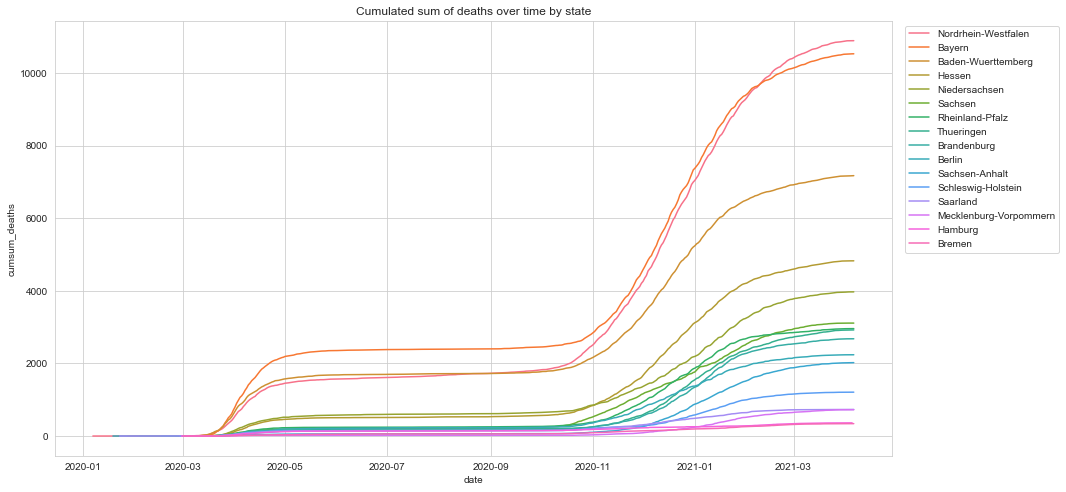

In [154]:
state_sum = new_covid_df_cleaned.groupby(by=["state", "date"]).sum()
state_sum = state_sum.replace([np.inf, -np.inf], 0)
state_sum["cumsum_deaths"] = state_sum.groupby(level=-2)["deaths"].cumsum()
state_sum = state_sum.reset_index()

plt.figure(figsize=(15, 8))
ln = sns.lineplot(data=state_sum.sort_values(
    "cumsum_deaths", ascending=False), x="date", y="cumsum_deaths", hue="state")
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Cumulated sum of deaths over time by state")
plt.show()


* Nodhein-Westfalen has the highest rate of increasing death rate and lowest one is Bremen. 

## Age and Gender

In [155]:
merged_data.head()

state              county age_group gender       date  cases  \
0  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F 2020-03-27      1   
1  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F 2020-03-28      1   
2  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F 2020-04-03      1   
3  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F 2020-10-18      1   
4  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F 2020-10-22      1   

   deaths  recovered  population  
0       0          1      261674  
1       0          1      261674  
2       0          1      261674  
3       0          1      261674  
4       0          1      261674

In [156]:
covidcases_by_age_group = new_covid_df_cleaned.groupby('age_group').sum()
covidcases_by_age_group= covidcases_by_age_group.reset_index()
covidcases_by_age_group.head(6)

age_group   cases  deaths  recovered
0     00-04   63146       8      54523
1     05-14  165341       7     147330
2     15-34  466144      75     433436
3     35-59  508872    1383     474218
4     60-79  338541   16057     297036
5     80-99  189010   39142     141246

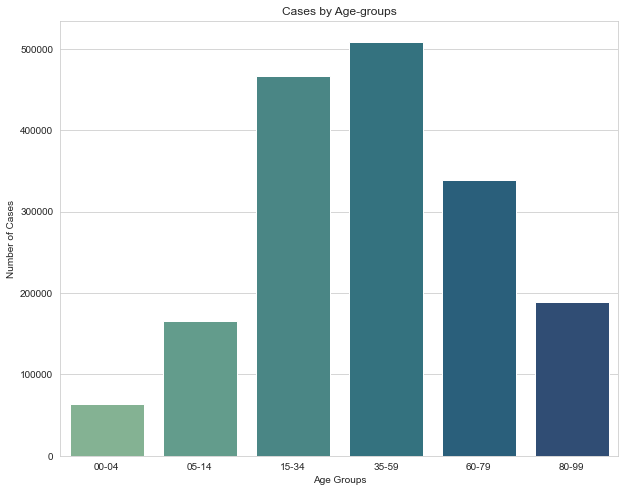

In [157]:
plt.figure(figsize=(10, 8))
sns.barplot(data = covidcases_by_age_group,  x = "age_group", y = "cases", palette="crest")
plt.title("Cases by Age-groups")
plt.xlabel('Age Groups')
plt.ylabel('Number of Cases')
plt.show()


* Age group of 35-59 has highest number of cases, followed by the group of 15-34, which are the age ranges that tend to commute to public places more. 
* Age group of 0-4 has lowest number of cases. 

In [158]:
covidcases_by_gender = new_covid_df_cleaned.groupby('gender').sum()
covidcases_by_gender = covidcases_by_gender.reset_index()
covidcases_by_gender.head(6)


gender   cases  deaths  recovered
0      F  872639   23825     785950
1      M  858415   32847     761839

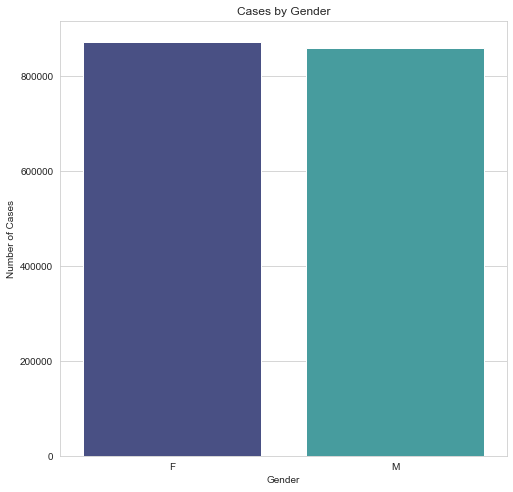

In [159]:
plt.figure(figsize=(8, 8))
sns.barplot(data = covidcases_by_gender, x="gender", y = "cases", palette="mako")
plt.title("Cases by Gender")
plt.xlabel('Gender')
plt.ylabel('Number of Cases')
plt.show()

* Female Covid 19 cases are higher than that of male only by a small margin. It can be concluded that Covid-19 cases occur equally in both genders. 

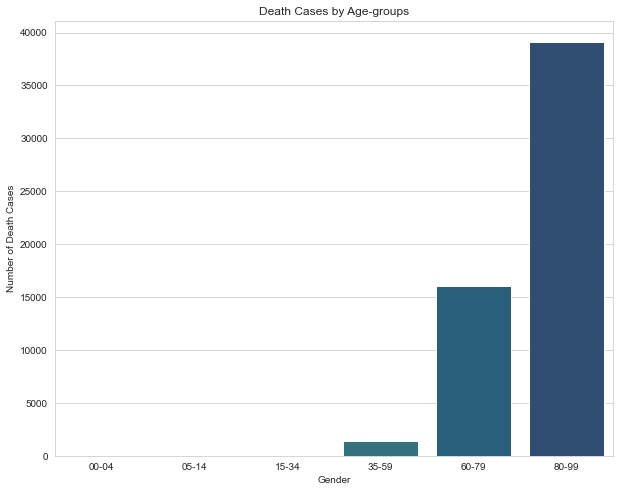

In [160]:
plt.figure(figsize=(10, 8))
sns.barplot(data=covidcases_by_age_group,
            x="age_group", y="deaths", palette="crest")
plt.title("Death Cases by Age-groups")
plt.xlabel('Gender')
plt.ylabel('Number of Death Cases')
plt.show()

* Even though age group of 80-99 has relatively lower cases by number, the death cases are around twice of other age-group combined. 

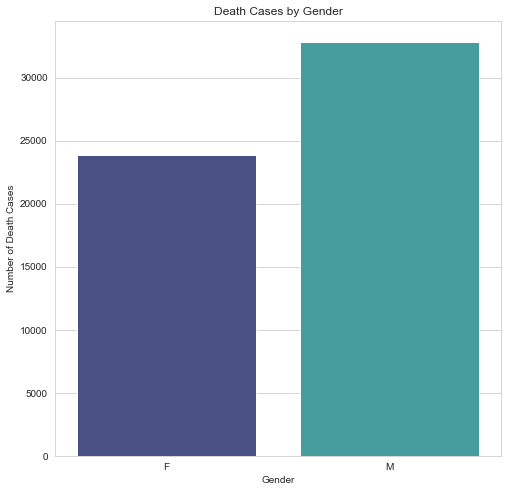

In [161]:
plt.figure(figsize=(8, 8))
sns.barplot(data=covidcases_by_gender, x="gender", y="deaths", palette="mako")
plt.title("Death Cases by Gender")
plt.xlabel('Gender')
plt.ylabel('Number of Death Cases')
plt.show()

* Covid-19 related deaths of males are relatively higher compared to females. 

#### What contributes to the spread of COVID-19 in Germany?
* When it comes to understanding what contributes to the spread of Covid-19 in Germany, we need to use an additonal dataset provided GoogleCloudPlatform. More info here [open-covid-19.github.io](https://open-covid-19.github.io/explorer/report/?key=DE)

<AxesSubplot:>

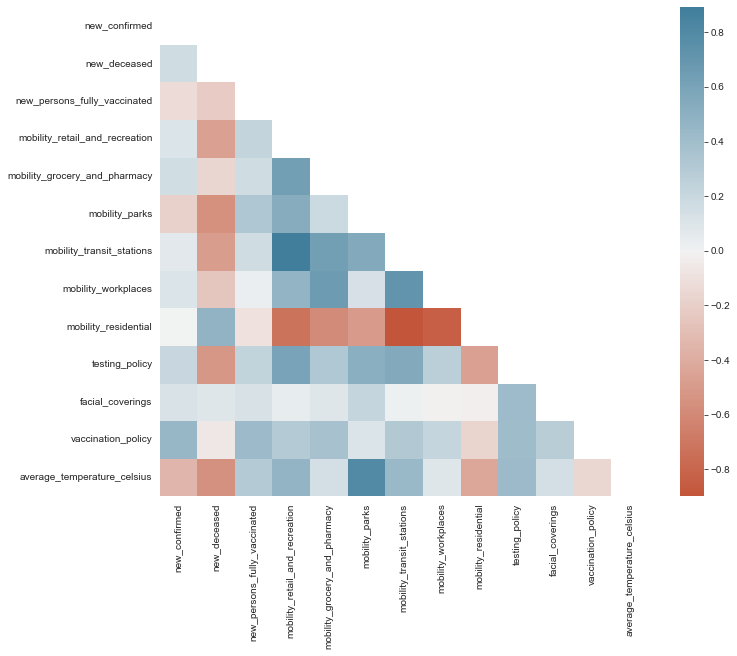

In [162]:
corr = google_covid_de.corr()
f, ax = plt.subplots(figsize=(11,9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(20, 230, as_cmap=True)
sns.heatmap(corr, cmap=cmap, square=True, mask=mask)

* By looking at the correlation table, we can see that `new confirmed cases` are negatively correlated with the average temperature. Meaning when the weather is colder, people tend to be sick more often.

* In addition to that, let's analyze how people's movement affects the spread of COVID-19.

<AxesSubplot:xlabel='date', ylabel='mobility_retail_and_recreation'>

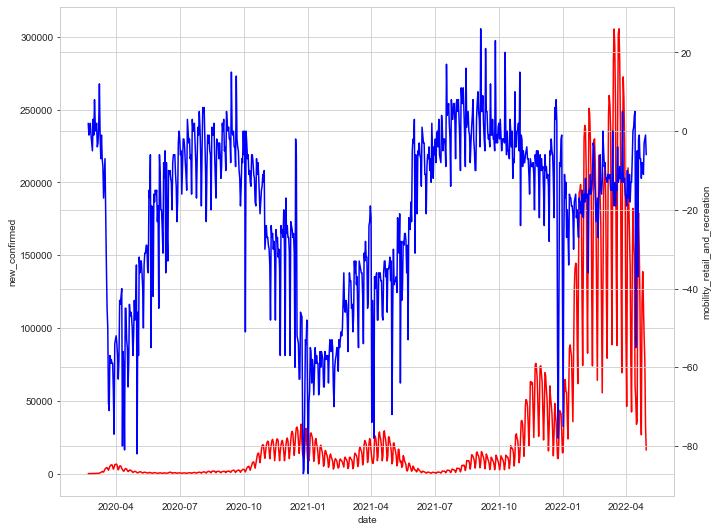

In [163]:
plt.figure(figsize=(11,9))
sns.lineplot(x='date', y='new_confirmed', data=google_covid_de, color='r')
ax2 = plt.twinx()
sns.lineplot(x='date', y='mobility_retail_and_recreation', data=google_covid_de, color='b', ax=ax2)

# Modeling

In [164]:
cov_model_df = new_covid_df_cleaned.groupby(by=["state", "county", 'age_group', 'gender']).sum()
# calculate the sum of cases deaths and recovered and cases for each gender, age_group, county and state

In [165]:
cov_model_df.reset_index(inplace=True)

In [166]:
new_merged = cov_model_df.merge(new_demographics_cleaned,
                                         how = 'inner', on = ['state', 'gender', 'age_group'])
# merge the demographics data in order to obtain population

In [167]:
new_merged.head()

state                       county age_group gender  cases  \
0  Baden-Wuerttemberg           LK Alb-Donau-Kreis     00-04      F     49   
1  Baden-Wuerttemberg                  LK Biberach     00-04      F     49   
2  Baden-Wuerttemberg             LK Bodenseekreis     00-04      F     46   
3  Baden-Wuerttemberg                LK Boeblingen     00-04      F    121   
4  Baden-Wuerttemberg  LK Breisgau-Hochschwarzwald     00-04      F     76   

   deaths  recovered  population  
0       0         41      261674  
1       0         44      261674  
2       0         43      261674  
3       0        108      261674  
4       0         70      261674

In [168]:
new_merged = new_merged.replace(['F', 'M'], [1, 0])

In [169]:
new_merged['deaths'] = np.where(new_merged['deaths']> 0 , 1, 0)

In [170]:
new_merged.isnull().sum()

state         0
county        0
age_group     0
gender        0
cases         0
deaths        0
recovered     0
population    0
dtype: int64

## Training and Testing

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [172]:
X=new_merged.drop(['state', 'county', 'age_group', 'deaths'], axis = 1)  # Features
y=new_merged['deaths']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Regression Modeling and Evaluation

In [173]:
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression()
#fitting on logistic regression model
logreg.fit(X_train, y_train)

#predicting on decemeber month data
y_pred = logreg.predict(X_test)

In [174]:
# Model Accuracy
print("Accuracy:",accuracy_score(y_test, y_pred) * 100)

Accuracy: 68.83468834688347


In [175]:
cf_matrix = confusion_matrix(y_test, y_pred)

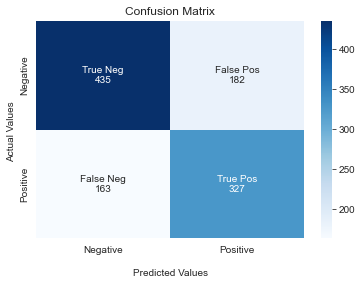

In [176]:
groups = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(val) for val in
                cf_matrix.flatten()]
labels = [f"{g1}\n{g2}" for g1, g2 in
          zip(groups, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
axes = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
axes.set_title('Confusion Matrix')
axes.set_xlabel('\nPredicted Values')
axes.set_ylabel('Actual Values ')
axes.xaxis.set_ticklabels(['Negative', 'Positive'])
axes.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

In [177]:
res_cfmatr = cf_matrix.flatten()
# precision = TP / (TP + FP)
precision = res_cfmatr[3] / (res_cfmatr[3] + res_cfmatr[1])
precision

0.6424361493123772

In [178]:
# recall = TP / (TP + FN)
recall = res_cfmatr[3] / (res_cfmatr[3] + res_cfmatr[2])
recall

0.6673469387755102

In [179]:
# f1 score = 2 * ((precision * recall)/ precision + recall)

f1score = 2 * ((precision * recall) / precision + recall)
f1score


2.669387755102041

In [180]:
cross_val_scores = cross_val_score(logreg, X, y,cv=10)

In [181]:
np.average(cross_val_scores)

0.7043794921644869

## Random Forest Modelling and evaluation

In [182]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [183]:

# Model Accuracy
print("Accuracy:",accuracy_score(y_test, y_pred) * 100)
# the accuracy is high so the Random forest model performed well

Accuracy: 86.72086720867209


In [184]:

cf_matrix = confusion_matrix(y_test, y_pred)

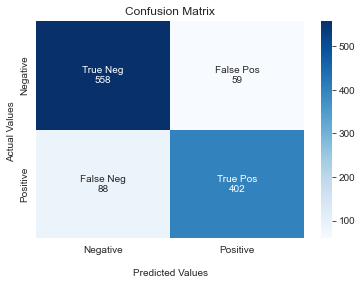

In [185]:
groups = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(val) for val in
cf_matrix.flatten()]
labels = [f"{g1}\n{g2}" for g1, g2 in
zip(groups,group_counts)]
labels = np.asarray(labels).reshape(2,2)
axes = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
axes.set_title('Confusion Matrix');
axes.set_xlabel('\nPredicted Values')
axes.set_ylabel('Actual Values ');
axes.xaxis.set_ticklabels(['Negative','Positive'])
axes.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

* from the above confusion matrix, the number of false negative and false positives are low which further shows the model performed well

In [186]:
res_cfmatr = cf_matrix.flatten()
# precision = TP / (TP + FP)
precision = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[1])
precision

0.8720173535791758

In [187]:
# recall = TP / (TP + FN)
recall = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[2])
recall

0.8204081632653061

In [188]:
# f1 score = 2 * ((precision * recall)/ precision + recall)

f1score = 2 * ((precision * recall)/ precision + recall)
f1score

3.2816326530612243

### Random Forest Cross Validation

In [189]:
cross_val_scores = cross_val_score(RandomForestClassifier(n_estimators=100), X, y,cv=10)
cross_val_scores

array([0.58536585, 0.88888889, 0.79403794, 0.61246612, 0.48780488,
       0.47696477, 0.4498645 , 0.47696477, 0.63858696, 0.75543478])

In [190]:
np.average(cross_val_scores)
# the average score for cross validation is very low but if you look at cross_val_scores array
# you see that it performed well only a few times. One reason for this can be overfitting but further analysis needs to be done

0.616637946270767

## K-NN Classifier Modeling and evaluation 

In [191]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)

In [192]:

# Model Accuracy
print("Accuracy:",accuracy_score(y_test, y_pred) * 100)

Accuracy: 94.85094850948511


In [193]:

cf_matrix = confusion_matrix(y_test, y_pred)

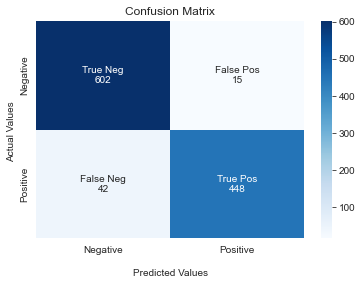

In [194]:
groups = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(val) for val in
cf_matrix.flatten()]
labels = [f"{g1}\n{g2}" for g1, g2 in
zip(groups,group_counts)]
labels = np.asarray(labels).reshape(2,2)
axes = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
axes.set_title('Confusion Matrix');
axes.set_xlabel('\nPredicted Values')
axes.set_ylabel('Actual Values ');
axes.xaxis.set_ticklabels(['Negative','Positive'])
axes.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

In [195]:
res_cfmatr = cf_matrix.flatten()
# precision = TP / (TP + FP)
precision = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[1])
precision

0.9676025917926566

In [196]:
# recall = TP / (TP + FN)
recall = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[2])
recall

0.9142857142857143

In [197]:
# f1 score = 2 * ((precision * recall)/ precision + recall)

f1score = 2 * ((precision * recall)/ precision + recall)
f1score

3.657142857142857

### KNN Cross Validation

In [198]:
cross_val_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), X, y,cv=10)
cross_val_scores

array([0.3902439 , 0.7398374 , 0.42276423, 0.52574526, 0.49593496,
       0.61246612, 0.49864499, 0.42276423, 0.51902174, 0.72282609])

In [199]:
np.average(cross_val_scores)

0.5350248910097796

| Model               | Accuracy | Precision | Recall | F1    | Cross-valid |
|---------------------|----------|-----------|--------|-------|-------------|
| Logistic Regression | 68.83    | 0.64      | 0.66   | 2.66  | 0.70        |
| Random Forest       | 86.72    | 0.87      | 0.82   | 3.28  | 0.61        |
| KNN                 | 94.85    | 0.96      | 0.91   | 3.657 | 0.53        |

* Logistic Regression was not performing as expected as it is linear and our training data sets was not calibrated well enough.
* Random forest performed better but it has issues with overfitting.
* KNN performs the best as its neighboring method is expected to perform better in population data and our data was not high dimensional. 
* Cross validation results were not promising for KNN and further analysis need to be done to know what are the underlying reasons. 